# Download user timelines
To see how these user-timelines were downloaded, see:

`sm_w2v.__main__.run_uer_timeline_download()`

Data were downloaded to:

`data/user_timeline_tweets.json`

In [1]:
# load and concatenate tweet timeline-documents
import json

user_timelines = dict()
with open('../data/user_timeline_tweets.json') as f_in:
    for l in f_in:
        try:
            twt = json.loads(l)
        except:
            continue
        user_id_str = twt['user']['id_str']
        if user_id_str in user_timelines:
            user_timelines[user_id_str] = user_timelines[user_id_str] + ' ' + twt['text']
        else:
            user_timelines[user_id_str] = twt['text']

# print(user_timelines['383303820'])

# clean/preprocess text

In [2]:
from gensim.parsing.preprocessing import STOPWORDS
import re

STOPWORDS_ = ['rt', '', 'httpst', 'amp', 'https\'']

def clean_text(text):
    clean = re.sub(r'http.*$', '', text)
    clean = re.sub(r'[^a-zA-Z\s]', '', clean)
    
    clean = clean.lower()
    word_list = clean.split()
    word_list = [w for w in word_list if (w not in STOPWORDS_ and w not in STOPWORDS)]
    
    return word_list

user_clean_timelines = dict()
for user_id_str in user_timelines.keys():
    user_clean_timelines[user_id_str] = clean_text(user_timelines[user_id_str])

# LDA topic modeling on timeline documents

In [3]:
from gensim.models.ldamodel import LdaModel
from gensim import corpora

user_timelines_keys = []
texts = []
for k, v in user_clean_timelines.items():
    user_timelines_keys.append(k)
    texts.append(v)

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.3, keep_n=100000)
corpus = [dictionary.doc2bow(text) for text in texts]

print('number of user-timelines:', len(corpus))
model = LdaModel(corpus, id2word=dictionary, num_topics=10, iterations=50, passes=5)

number of user-timelines: 275


In [4]:
model.save('../models/lda_user_timelines.model')
model = LdaModel.load('../models/lda_user_timelines.model')

In [5]:
# idenitify topics of interest
model.print_topics(20)

[(0,
  '0.017*rs + 0.013*hacking + 0.010*del + 0.009*playlist + 0.008*lana + 0.008*hawaii + 0.008*rey + 0.007*golf + 0.007*tested + 0.006*flat'),
 (1,
  '0.034*union + 0.033*blm + 0.033*occupy + 0.021*bitcoin + 0.020*marketing + 0.020*feelthebern + 0.016*web + 0.008*rs + 0.008*fx + 0.008*forex'),
 (2,
  '0.006*somalia + 0.005*lgbt + 0.004*ootd + 0.003*brussels + 0.003*tech + 0.003*alzheimers + 0.002*isis + 0.002*athens + 0.002*cnn + 0.002*minister'),
 (3,
  '0.023*hiring + 0.022*tech + 0.019*howto + 0.012*prep + 0.006*prevention + 0.006*ias + 0.005*hivaids + 0.004*technology + 0.003*stigma + 0.003*ca'),
 (4,
  '0.026*nonsense + 0.011*sos + 0.010*dg + 0.005*chinas + 0.005*thewalkingdead + 0.004*syria + 0.003*worship + 0.003*isis + 0.002*jesus + 0.002*holy'),
 (5,
  '0.025*closed + 0.023*que + 0.019*del + 0.016*para + 0.015*por + 0.014*los + 0.013*es + 0.012*milan + 0.011*las + 0.009*realdonaldtrump'),
 (6,
  '0.012*eau + 0.007*archives + 0.006*prolife + 0.005*remedies + 0.005*rid + 0.00

In [6]:
# show users vs. features (topics)
features = dict()

for i, doc in enumerate(corpus):
    features[user_timelines_keys[i]] = model.get_document_topics(doc, minimum_probability=None)


In [7]:
# do time-plot of features for a specific user (topics) vs. time
import pandas as pd
import numpy as np

columns = ['topic1', 'topic2', 'topic3', 'topic4', 'topic5',
           'topic6', 'topic7', 'topic8', 'topic9', 'topic10']
index = user_timelines_keys
df = pd.DataFrame(data=np.zeros((len(index), len(columns))), columns=columns, index=index)

for doc_ind, user_doc in enumerate(features.values()):
    for topic in user_doc:
        df.iloc[doc_ind, topic[0]] = topic[1]

In [8]:
df.head()

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
463577491,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.997124
2444516970,0.069997,0.000000,0.119991,0.155493,0.000000,0.000000,0.630134,0.024293,0.000000,0.000000
106135511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999519
1673198515,0.020003,0.020002,0.819970,0.020003,0.020004,0.020002,0.020004,0.020007,0.020003,0.020002
390581131,0.000000,0.000000,0.820754,0.000000,0.169259,0.000000,0.000000,0.000000,0.000000,0.000000


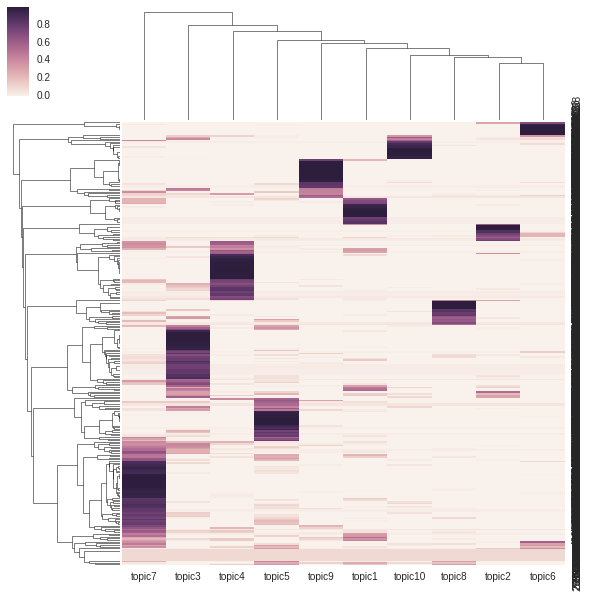

In [9]:
import seaborn as sns
%matplotlib inline

sns.clustermap(df)

In [10]:
# do Doc2Vec to cluster user-timelines (documents)